In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [0]:

vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters 
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:13<00:00, 44166423.41it/s]


In [0]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

In [0]:
def load_image(img_path, max_size=400, shape=None):
    
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [0]:
# load in content and style image
content = load_image('images/photo.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/ni.jpg',shape=content.shape[-2:]).to(device)

In [0]:
#can be done using a DataLoader method , but since only using a single image , can do it for each image , ie 2
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)

  return image

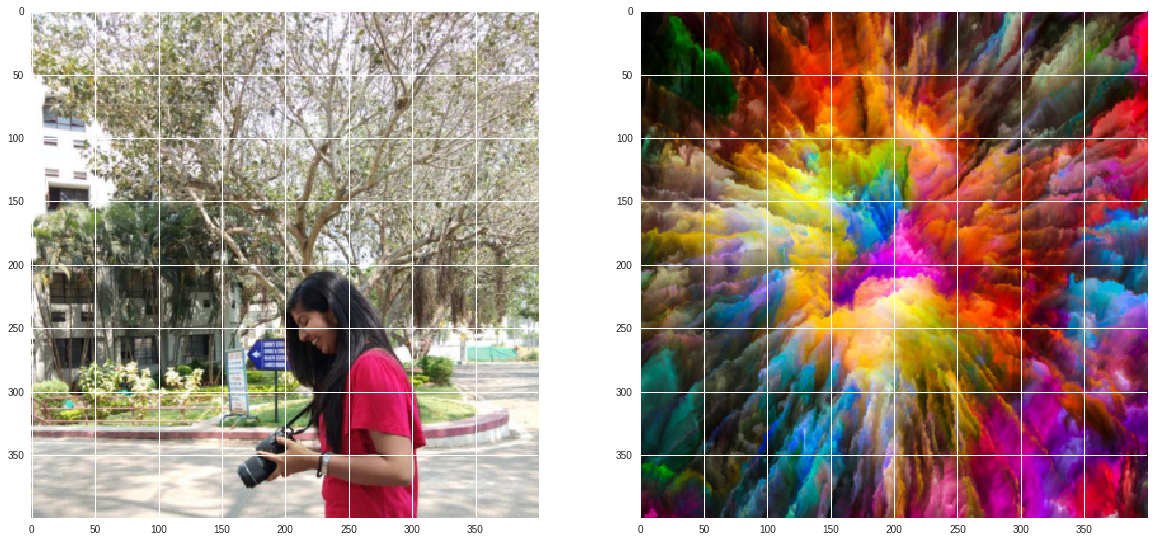

In [0]:
fig , (ax1 , ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:

def get_features(image , model , layers=None):
  if layers is None:
    layers ={'0':'conv1_1',
            '5':'conv2_1' , 
            '10':'conv3_1',
            '19':'conv4_1',
            '21':'conv4_2',
            '28':'conv5_1',
            }
    
    
  features ={}
  x = image
  for name  , layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]]=x
  return features

In [0]:
def gram_matrix(tensor):
  _ ,d ,h,w=tensor.size()
  tensor =tensor.view(d , h*w)
  gram = torch.mm(tensor , tensor.t())
  
  return gram

In [0]:
content_features = get_features( content,vgg)
style_features = get_features(style , vgg)
style_grams ={layer:gram_matrix(style_features[layer]) for layer in style_features}
target = content.clone().requires_grad_(True).to(device)

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  
style_weight = 1e6  

In [0]:
# for displaying the target image
show_every = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003) #adam is better than almost any optimiser 
steps = 5000  # decide how many iterations to update your image 

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()